# Validation Reduced-Order SG VBR models & controllers with SMIB System

## Import dpsimpy

In [1]:
import sys
sys.path.insert(0,'/home/mmo-cya/dpsim/build')
#sys.path.remove('/home/mmo/git/lund-anm-control')
import dpsimpy



## Load PSAT Results

In [2]:
from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *
import os
import urllib.request

if not os.path.exists('reference-results'):
    os.mkdir('reference-results')

url = 'https://raw.githubusercontent.com/dpsim-simulator/reference-results/master/PSAT/SMIB-Fault/PSAT_3OrderSyGen_SMIB_Fault_100mS_TS_1mS.out.txt'
local_file_3Order = 'reference-results/PSAT_3OrderSyGen_SMIB_Fault_100mS_TS_1mS.out'
urllib.request.urlretrieve(url, local_file_3Order) 
ts_psat_3Order = read_timeseries_dpsim(local_file_3Order)

url = 'https://raw.githubusercontent.com/dpsim-simulator/reference-results/master/PSAT/SMIB-Fault/PSAT_4OrderSyGen_SMIB_Fault_100mS_TS_1mS.out.txt'
local_file_4Order = 'reference-results/PSAT_4OrderSyGen_SMIB_Fault_100mS_TS_1mS.out'
urllib.request.urlretrieve(url, local_file_4Order)
ts_psat_4Order = read_timeseries_dpsim(local_file_4Order)

url = 'https://raw.githubusercontent.com/dpsim-simulator/reference-results/master/PSAT/SMIB-Fault/PSAT_6OrderSyGen_SMIB_Fault_100mS_TS_1mS.out.txt'
local_file_6Order = 'reference-results/PSAT_6OrderSyGen_SMIB_Fault_100mS_TS_1mS.out'
urllib.request.urlretrieve(url, local_file_6Order)
ts_psat_6Order = read_timeseries_dpsim(local_file_6Order)

column number: 11
results length: 20003
real column names: ['delta', 'omega', 'eq_t', 'theta_bus1', 'theta_bus3', 'V_Bus1', 'V_Bus3', 'vf', 'pm', 'p', 'q']
complex column names: []
column number: 12
results length: 20003
real column names: ['delta', 'omega', 'eq_t', 'ed_t', 'theta_bus1', 'theta_bus3', 'V_Bus1', 'V_Bus3', 'vf', 'pm', 'p', 'q']
complex column names: []
column number: 14
results length: 20003
real column names: ['delta', 'omega', 'eq_t', 'ed_t', 'eq_s', 'ed_s', 'theta_bus1', 'theta_bus3', 'V_Bus1', 'V_Bus3', 'vf', 'pm', 'p', 'q']
complex column names: []


## Calculate $V_d$, $V_q$, $I_d$ and $I_q$ in PSAT

### 3th Order Model

In [3]:
#calculate vd and vq
angle = ts_psat_3Order['delta'].values - ts_psat_3Order['theta_bus1'].values
V_bus1 = ts_psat_3Order['V_Bus1'].values
vd = V_bus1 * np.sin(angle)
ts_psat_3Order['vd'] = TimeSeries('vd', ts_psat_3Order['V_Bus1'].time, vd)
vq = V_bus1 * np.cos(angle)
ts_psat_3Order['vq'] = TimeSeries('vq', ts_psat_3Order['V_Bus1'].time, vq)

#calculate id and iq in PSAT
Xd_t = 0.299900
Xq = 1.7600
i_d = (ts_psat_3Order['eq_t'].values - ts_psat_3Order['vq'].values) / Xd_t
ts_psat_3Order['id'] = TimeSeries('id', ts_psat_3Order['eq_t'].time, i_d)
i_q = ts_psat_3Order['vd'].values / Xq
ts_psat_3Order['iq'] = TimeSeries('iq', ts_psat_3Order['vd'].time, i_q)

### 4th Order Model

In [4]:
#calculate vd and vq
angle = ts_psat_4Order['delta'].values - ts_psat_4Order['theta_bus1'].values
V_bus1 = ts_psat_4Order['V_Bus1'].values
vd = V_bus1 * np.sin(angle)
ts_psat_4Order['vd'] = TimeSeries('vd', ts_psat_4Order['V_Bus1'].time, vd)
vq = V_bus1 * np.cos(angle)
ts_psat_4Order['vq'] = TimeSeries('vq', ts_psat_4Order['V_Bus1'].time, vq)
    
#calculate id and iq in PSAT
Xd = 0.299900
Xq = 0.650000
i_d = (ts_psat_4Order['eq_t'].values - ts_psat_4Order['vq'].values) / Xd
ts_psat_4Order['id'] = TimeSeries('id', ts_psat_4Order['eq_t'].time, i_d)
i_q = -(ts_psat_4Order['ed_t'].values - ts_psat_4Order['vd'].values) / Xq
ts_psat_4Order['iq'] = TimeSeries('iq', ts_psat_4Order['ed_t'].time, i_q)

### 6th Order Model (Marconato's model)

In [5]:
#calculate vd and vq
angle = ts_psat_6Order['delta'].values - ts_psat_6Order['theta_bus1'].values
V_bus1 = ts_psat_6Order['V_Bus1'].values
vd = V_bus1 * np.sin(angle)
ts_psat_6Order['vd'] = TimeSeries('vd', ts_psat_6Order['V_Bus1'].time, vd)
vq = V_bus1 * np.cos(angle)
ts_psat_6Order['vq'] = TimeSeries('vq', ts_psat_6Order['V_Bus1'].time, vq)

#calculate id and iq in PSAT\n",
Xd_s = 0.2299
Xq_s = 0.2500
i_d = (ts_psat_6Order['eq_s'].values - ts_psat_6Order['vq'].values) / Xd_s
ts_psat_6Order['id'] = TimeSeries('id', ts_psat_6Order['eq_s'].time, i_d)
i_q = -(ts_psat_6Order['ed_s'].values - ts_psat_6Order['vd'].values) / Xq_s
ts_psat_6Order['iq'] = TimeSeries('iq', ts_psat_6Order['ed_s'].time, i_q)

## Define nominal values

In [6]:
# nominal values (per unit)
nominal_values = {}
nominal_values['Te'] = 0.540541
nominal_values['Edq0_0'] = 0.403062     #4th order model
nominal_values['Edq0_1'] = 0.944802     #3th and 4th order model
nominal_values['Edq0_t_0'] = 0.392200   #6 order model
nominal_values['Edq0_t_1'] = 0.946405   #6 order model
nominal_values['Edq0_s_0'] = 0.548309   #6 order model
nominal_values['Edq0_s_1'] = 0.918731   #6 order model
nominal_values['Vdq0_0'] = 0.639089
nominal_values['Vdq0_1'] = 0.833106
nominal_values['Idq0_0'] = 0.372443
nominal_values['Idq0_1'] = 0.363119
nominal_values['delta'] = 0.909230
nominal_values['w_r'] = 1.0

nominal_grid_voltage = 24e3

#
titles = {}
titles['Te'] = 'Electrical Torque'
titles['Edq0_0'] = 'd-component of the voltage behind the transient reactance'
titles['Edq0_1'] = 'q-component of the voltage behind the transient reactance'
titles['Edq0_t_0'] = 'd-component of the voltage behind the transient reactance'
titles['Edq0_t_1'] = 'd-component of the voltage behind the transient reactance'
titles['Edq0_s_0'] = 'd-component of the voltage behind the sub-transient reactance'
titles['Edq0_s_1'] = 'd-component of the voltage behind the sub-transient reactance'
titles['Vdq0_0'] = 'd-component of the terminal voltage'
titles['Vdq0_1'] = 'q-component of the terminal voltage'
titles['Idq0_0'] = 'd-component of the terminal current'
titles['Idq0_1'] = 'q-component of the terminal current'
titles['delta'] = 'Delta'
titles['w_r'] = 'Mechanical Omega'

#
ylabels = {}
ylabels['Te'] = 'Torque (p.u.)'
ylabels['Edq0_0'] = 'Ed_t (p.u.)'
ylabels['Edq0_1'] = 'Eq_t (p.u.)'
ylabels['Edq0_t_0'] = 'Ed_t (p.u.)'
ylabels['Edq0_t_1'] = 'Eq_t (p.u.)'
ylabels['Edq0_s_0'] = 'Ed_s (p.u.)'
ylabels['Edq0_s_1'] = 'Eq_s (p.u.)'
ylabels['Vdq0_0'] = 'Vd (p.u.)'
ylabels['Vdq0_1'] = 'Vq (p.u.)'
ylabels['Idq0_0'] = 'Id (p.u.)'
ylabels['Idq0_1'] = 'Iq (p.u.)'
ylabels['delta'] = 'Delta (rad)'
ylabels['w_r'] = 'w_r (p.u.)'

## Declare plot function

In [7]:
import matplotlib.pyplot as plt

timestep_common = 10e-6
t_begin = 0
t_end = 10
begin_idx = int(t_begin/timestep_common)
end_idx= int(t_end/timestep_common)
time = np.linspace(t_begin, t_end, num=end_idx-begin_idx)

#plot parameters
width = 12
height = 4

def plot_variable(title, varname_dpsim, varname_psat, ts_dpsim, ts_psat, nominal_values, ylabels):
    fig1 = plt.figure(figsize=(width, height))
    dpsim_values = ts_dpsim[varname_dpsim].interpolate(timestep_common).values[begin_idx:end_idx]
    psat_values = ts_psat[varname_psat].interpolate(timestep_common).values[begin_idx:end_idx]
    plt.plot(time, dpsim_values, label='DPSim')
    plt.plot(time, psat_values, '--', label='PSAT')
    plt.legend(loc='lower right')
    plt.xlabel('time (s)')
    plt.ylabel(ylabels[varname_dpsim])
    plt.grid()
    plt.xlim([t_begin, t_end])
    plt.show
    
    #calculate RMSE
    nom_value = nominal_values[varname_dpsim]
    rmse = np.sqrt(((dpsim_values - psat_values) ** 2).mean())
    print('RMSE {:s}  = {:.6f} (pu), which is {:.3f}% of the nominal value = {:.3f} (pu) '.format(varname_dpsim, rmse, rmse/nom_value*100, nom_value))
        
    return rmse/nom_value*100

def plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim, ts_psat, nominal_voltage, ylabels):
    
    #convert dpsim voltage to magnitude value and per-unit for comparison with psat
    dpsim_values_abs_pu = ts_dpsim[varname_dpsim].interpolate(timestep_common).abs().values[begin_idx:end_idx]/nominal_voltage
    psat_values = ts_psat[varname_psat].interpolate(timestep_common).values[begin_idx:end_idx]
    
    fig1 = plt.figure(figsize=(width, height))
    plt.plot(time, dpsim_values_abs_pu, label='DPSim')
    plt.plot(time, psat_values, '--', label='PSAT')
    plt.legend(loc='lower right')
    plt.xlabel('time (s)')
    plt.show
      
     #calculate RMSE
    rmse = np.sqrt(((dpsim_values_abs_pu - psat_values) ** 2).mean())
    print('RMSE {:s}  = {:.6f} (pu), which is {:.3f}% of the nominal value = {:.3f} (pu) '.format(varname_dpsim, rmse, rmse/1.0*100, 1.0))
        
    return rmse/1.0*100


def plot_node_volt_angle(varname_dpsim, varname_psat, ts_dpsim, ts_psat, nominal_voltage, ylabels):
    #limit rmse to post-fault evaluation
    t_post_begin=1.1
    t_post_end=t_end
    begin_post_idx = int(t_post_begin/timestep_common)
    end_post_idx= int(t_post_end/timestep_common)
    time_post = np.linspace(begin_post_idx, end_post_idx, num=end_post_idx-begin_post_idx)
    
    dpsim_values = ts_dpsim[varname_dpsim].interpolate(timestep_common).phase().values[begin_idx:end_idx]
    dpsim_values_post = dpsim_values[begin_post_idx:end_post_idx]
    psat_values = ts_psat[varname_psat].interpolate(timestep_common).values[begin_idx:end_idx]/np.pi*180
    psat_values_post = psat_values[begin_post_idx:end_post_idx]
    
    fig2 = plt.figure(figsize=(width, height))
    plt.plot(time, dpsim_values, label='DPSim')
    plt.plot(time, psat_values, '--', label='PSAT')
    plt.legend(loc='lower right')
    plt.xlabel('time (s)')
    plt.show
    
     #calculate RMSE
    rmse = np.sqrt(((dpsim_values_post - psat_values_post) ** 2).mean())
    print('RMSE Post-Fault {:s}  = {:.6f} (deg)'.format(varname_dpsim, rmse))
        
    return rmse

## Parametrization

In [8]:
from math import sqrt, pi

### Power System
nominal_voltage_hv = 230e3
nominal_voltage_mv = 24e3
ratio = nominal_voltage_mv/nominal_voltage_hv
frequency = 60
omega = 2 * pi * frequency

### Generator
nom_power = 555e6
set_point_active_power = 300e6
set_point_voltage = 1.05*nominal_voltage_mv
H = 3.7
Td0_t = 8.0669
Td0_s = 0.0300
Td_t = 1.3368
Td_s = 0.0230
Ld_t = 0.2999
Ld_s = 0.2299
Tq0_t = 0.9991
Tq0_s = 0.0700
Lq_t = 0.6500
Lq_s = 0.2500
Ld = 1.8099
Lq = 1.7600
L0 = 0.15
Taa = 0

### Excitation system
Ka = 46
Ta = 0.06
Ke = -0.0435
Te = 0.46
Kf = 0.1
Tf = 1
Tr = 0.02

### Turbine Goverour
OmegaRef = 1.0
R = 0.02
Tmax = 1.2
Tmin = 0.3
Ts = 0.1
Tc = 0.45
T3 = 0.0
T4 = 12.0
T5 = 50.0
        
### PiLine parameters calculated from CIGRE Benchmark system
line_length = 100
line_resistance = 1.27e-4 * 529 * line_length * pow(ratio,2)
line_inductance = 9.05e-4 * 529 / omega * line_length * pow(ratio,2)
line_capacitance = (1.81e-3 / 529) / omega * line_length / pow(ratio,2)
line_conductance = 0

### Switch
switch_closed = 0.001 * (24*24/555)
switch_open = 1e6

## Run powerflow for Initialization

In [9]:
sim_name_pf = "SP_ReducedOrderSG_SMIB_" + "PF_"
dpsimpy.Logger.set_log_dir("logs/" + sim_name_pf)

### Nodes
gnd_pf = dpsimpy.sp.SimNode.gnd
n1_pf  = dpsimpy.sp.SimNode('n1_pf', dpsimpy.PhaseType.Single)
n2_pf  = dpsimpy.sp.SimNode('n2_pf', dpsimpy.PhaseType.Single)

### Components

# syncrhon generator
gen_pf = dpsimpy.sp.ph1.SynchronGenerator('gen_pf', dpsimpy.LogLevel.debug)
gen_pf.set_parameters(rated_apparent_power=nom_power, rated_voltage=nominal_voltage_mv, 
                      set_point_active_power=set_point_active_power, set_point_voltage=set_point_voltage, 
                      powerflow_bus_type=dpsimpy.PowerflowBusType.PV)

gen_pf.set_base_voltage(nominal_voltage_mv)
gen_pf.modify_power_flow_bus_type(dpsimpy.PowerflowBusType.PV)

# Grid bus as Slack
extnet_pf = dpsimpy.sp.ph1.NetworkInjection("Slack", dpsimpy.LogLevel.debug)
extnet_pf.set_parameters(nominal_voltage_mv)
extnet_pf.set_base_voltage(nominal_voltage_mv)
extnet_pf.modify_power_flow_bus_type(dpsimpy.PowerflowBusType.VD)

# PiLine
pi_line_pf = dpsimpy.sp.ph1.PiLine('Pi_Line_pf', dpsimpy.LogLevel.debug)
pi_line_pf.set_parameters(R=line_resistance, L=line_inductance, C=line_capacitance, G=line_conductance)
pi_line_pf.set_base_voltage(nominal_voltage_mv)

### Connections
gen_pf.connect([n1_pf])
pi_line_pf.connect([n2_pf, n1_pf])
extnet_pf.connect([n2_pf])

### Define system topology
system_pf = dpsimpy.SystemTopology(frequency, [n1_pf, n2_pf], [gen_pf, pi_line_pf, extnet_pf])

# Logging
logger_pf = dpsimpy.Logger(sim_name_pf)
logger_pf.log_attribute('n1.v', 'v', n1_pf)
logger_pf.log_attribute('n2.v', 'v', n2_pf)
logger_pf.log_attribute('p_inj', 'p_inj', extnet_pf)
logger_pf.log_attribute('q_inj', 'q_inj', extnet_pf)

sim_pf = dpsimpy.Simulation(sim_name_pf, dpsimpy.LogLevel.debug)
sim_pf.set_system(system_pf)
sim_pf.set_domain(dpsimpy.Domain.SP)
sim_pf.set_solver(dpsimpy.Solver.NRP)
sim_pf.set_solver_component_behaviour(dpsimpy.SolverBehaviour.Initialization)
sim_pf.set_time_step(0.1)
sim_pf.set_final_time(0.5)
sim_pf.add_logger(logger_pf)
sim_pf.run()

[14:41:01.665062 Pi_Line_pf warning] Zero value for Conductance, setting default value of G=1e-06 [S]
[14:41:01.666310 SP_ReducedOrderSG_SMIB_PF_ info] Initialize simulation: SP_ReducedOrderSG_SMIB_PF_
[14:41:01.668102 SP_ReducedOrderSG_SMIB_PF_ info] Scheduling tasks.
[14:41:01.668321 SP_ReducedOrderSG_SMIB_PF_ info] Scheduling done.
[14:41:01.668325 SP_ReducedOrderSG_SMIB_PF_ info] Opening interfaces.
[14:41:01.668326 SP_ReducedOrderSG_SMIB_PF_ info] Start synchronization with remotes on interfaces
[14:41:01.668328 SP_ReducedOrderSG_SMIB_PF_ info] Synchronized simulation start with remotes
[14:41:01.668331 SP_ReducedOrderSG_SMIB_PF_ info] Start simulation: SP_ReducedOrderSG_SMIB_PF_
[14:41:01.668336 SP_ReducedOrderSG_SMIB_PF_ info] Time step: 1.000000e-01
[14:41:01.668339 SP_ReducedOrderSG_SMIB_PF_ info] Final time: 5.000000e-01
[14:41:01.670088 SP_ReducedOrderSG_SMIB_PF_ info] Simulation calculation time: 0.001745
[14:41:01.670134 SP_ReducedOrderSG_SMIB_PF_ info] Simulation finished

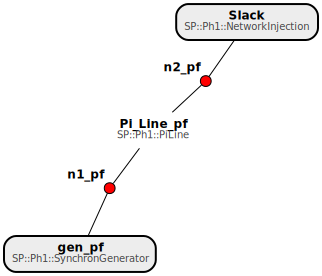

In [10]:
system_pf

In [11]:
system_pf.list_idobjects()



{'Pi_Line_pf': 'SP::Ph1::PiLine',
 'Slack': 'SP::Ph1::NetworkInjection',
 'gen_pf': 'SP::Ph1::SynchronGenerator',
 'n1_pf': 'SimNode<std::complex<double> >',
 'n2_pf': 'SimNode<std::complex<double> >'}

In [12]:
print(system_pf.list_idobjects()['Pi_Line_pf'])
print(type(system_pf.list_idobjects()['Pi_Line_pf']))

SP::Ph1::PiLine
<class 'str'>


In [13]:
system_pf.components

In [14]:
print(system_pf.components[0])

Attribute list for object with name gen_pf:
name                          type                size           value                         
-----------------------------------------------------------------------------------------------
P_set                         Real                               300000000.000000              
P_set_pu                      Real                               0.300000                      
Q_set                         Real                               43411881.878627               
Q_set_pu                      Real                               0.043412                      
V_set                         Real                               25200.000000                  
V_set_pu                      Real                               1.050000                      
base_Voltage                  Real                               24000.000000                  
i_intf                        MatrixComplex       1x1            [...]                      

In [15]:
system_pf.components[1].attr("R_series")

0.073152

In [16]:
sim_pf.get_idobj_attr('Pi_Line_pf', 'R_series')

0.073152

In [17]:
# sim_pf.get_idobj_attr(comp_name, 'P').get() * w_mw
print(system_pf.nodes[0])

Attribute list for object with name n1_pf:
name                          type                size           value                         
-----------------------------------------------------------------------------------------------
name                          String                             "n1_pf"                       
s                             MatrixComplex       1x1            [...]                         
uid                           String                             "n1_pf"                       
v                             MatrixComplex       1x1            [...]                         
voltage_init                  MatrixComplex       1x1            [...]                         



In [18]:
system_pf.components_at_node
T = dpsimpy.sp.ph1.Transformer("Name")
print(T)

Attribute list for object with name Name:
name                          type                size           value                         
-----------------------------------------------------------------------------------------------
L                             Real                               0.000000                      
R                             Real                               0.000000                      
S                             Real                               0.000000                      
base_Voltage                  Real                               0.000000                      
current_vector                MatrixComplex       2x1            [...]                         
i_intf                        MatrixComplex       1x1            [...]                         
name                          String                             "Name"                        
nominal_voltage_end1          Real                               0.000000                     

In [19]:
print(system_pf.list_idobjects())
cv = sim_pf.get_idobj_attr(n1_pf.name(), 'v').get()[0]
import numpy as np
print(cv)
np.linalg.norm(cv)
type(cv)
cmath.phase(cv)
cmath.phase(complex(1,1))


{'Pi_Line_pf': 'SP::Ph1::PiLine', 'Slack': 'SP::Ph1::NetworkInjection', 'gen_pf': 'SP::Ph1::SynchronGenerator', 'n1_pf': 'SimNode<std::complex<double> >', 'n2_pf': 'SimNode<std::complex<double> >'}
[24385.9808784+6353.2618865j]


0.7853981633974483

In [20]:
system_pf.components[1].attr("current_vector")

(-6959.57,-331.44)
 (6901.95,770.362)

### Validation DPSim to CIM


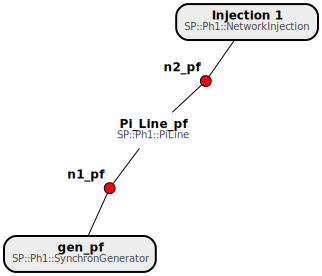

In [21]:
from cimpy import DPsimToCIMpy              ## Für Martin
from cimpy import CIMpyToDPsim
from cimpy.CIMpyToDPsim import Domain

network2test = DPsimToCIMpy.DPsimToCIMpy(system_pf, sim_pf)
net, K = CIMpyToDPsim.CIMpyToDPsim(network2test, Domain.PF)
net


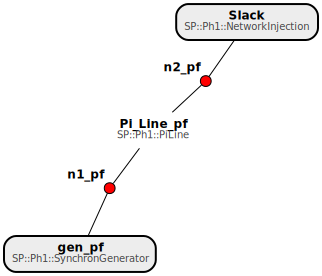

In [22]:
system_pf

### DPSim to CIMpy

In [23]:
network = dict(meta_info={}, topology={})
import numpy
from cimpy import CIMpyToDPsim
from cimpy import utils
from cimpy.cgmes_v2_4_15 import BaseVoltage

B1 = utils.create_BaseVoltage(24000)

network = utils.add_TopologicalNode(network, "cgmes_v2_4_15", B1,0,0, "n1_pf")
network = utils.add_TopologicalNode(network, "cgmes_v2_4_15", B1,0,0, "n2_pf")

# PiLine Parameters
name = system_pf.components[1].name()

r = float(str(system_pf.components[1].attr("R_series")))
x= float(str(system_pf.components[1].attr("L_series"))) * (2*numpy.pi*frequency)
bch= float(str(system_pf.components[1].attr("C_parallel"))) * (2*numpy.pi*frequency)
gch = float(str(system_pf.components[1].attr("G_parallel")))


network = utils.add_ACLineSegment(network, "cgmes_v2_4_15", "n1_pf", "n2_pf", r, x, bch, gch, B1,name)

network = utils.add_external_network_injection(network, "cgmes_v2_4_15", "n2_pf", 1)

# Generator Parameters
p = float(str(system_pf.components[0].attr("P_set")))
q = float(str(system_pf.components[0].attr("Q_set")))

ratedS = sqrt(p*p+q*q)
ratedU = float(str(system_pf.components[0].attr("base_Voltage")))
targetValue = float(str(system_pf.components[0].attr("V_set")))
initialP = float(str(system_pf.components[0].attr("P_set_pu")))

name = system_pf.components[0].name()
network = utils.add_SynchronousMachine(network, "cgmes_v2_4_15", "n1_pf", p, q, ratedS, ratedU, targetValue, initialP, name)
network 

{'meta_info': {},
 'topology': {'n1_pf': <cimpy.cgmes_v2_4_15.TopologicalNode.TopologicalNode at 0x7ffb92e837c0>,
  'n1_pf-sv': <cimpy.cgmes_v2_4_15.SvVoltage.SvVoltage at 0x7ffb92e839a0>,
  'n2_pf': <cimpy.cgmes_v2_4_15.TopologicalNode.TopologicalNode at 0x7ffb92e83310>,
  'n2_pf-sv': <cimpy.cgmes_v2_4_15.SvVoltage.SvVoltage at 0x7ffb92e832b0>,
  'Terminal_1_Pi_Line_pf': <cimpy.cgmes_v2_4_15.Terminal.Terminal at 0x7ffb92e83a90>,
  'Terminal_2_Pi_Line_pf': <cimpy.cgmes_v2_4_15.Terminal.Terminal at 0x7ffb65003b50>,
  'Pi_Line_pf': <cimpy.cgmes_v2_4_15.ACLineSegment.ACLineSegment at 0x7ffb65003b20>,
  'Terminal Injection 1': <cimpy.cgmes_v2_4_15.Terminal.Terminal at 0x7ffb92e834c0>,
  'Regulating Control 1': <cimpy.cgmes_v2_4_15.RegulatingControl.RegulatingControl at 0x7ffb92e835b0>,
  'Injection 1': <cimpy.cgmes_v2_4_15.ExternalNetworkInjection.ExternalNetworkInjection at 0x7ffb650036a0>,
  'Terminal_gen_pf': <cimpy.cgmes_v2_4_15.Terminal.Terminal at 0x7ffb65003670>,
  'RegulatingContro

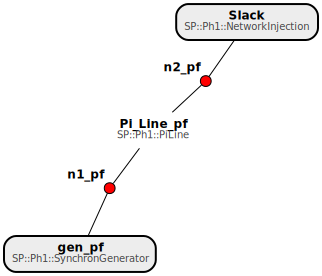

In [24]:
system_pf

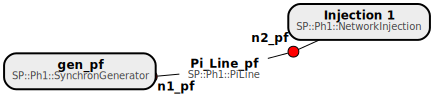

In [25]:
test_system, compsp = CIMpyToDPsim.CIMpyToDPsim(network, Domain.PF)
test_system


## Declare DPSim Topology for SP simulations

In [26]:
def sp_reducedOrderSG_SMIB_fault(sim_pf, gen_pf, gen_model, final_time=20, time_step=0.001):
    
    # ## Extract relevant powerflow results
    init_electrical_power = gen_pf.get_apparent_power()
    init_mechanical_power = gen_pf.get_apparent_power().real

    ### DPsim SP simulation
    name = "SP_ReducedOrderSG_SMIB_" + gen_model
    dpsimpy.Logger.set_log_dir("logs/" + name)
    
    ### Nodes
    gnd = dpsimpy.sp.SimNode.gnd
    n1 = dpsimpy.sp.SimNode('n1', dpsimpy.PhaseType.Single) 
    n1.set_initial_voltage(sim_pf.get_idobj_attr(n1_pf.name(), 'v').get()[0])

    n2 = dpsimpy.sp.SimNode('n2', dpsimpy.PhaseType.Single)
    n2.set_initial_voltage(sim_pf.get_idobj_attr(n2_pf.name(), 'v').get()[0])


    ### Components

    # syncrhon generator
    gen = None
    if (gen_model=="3Order"):
        gen = dpsimpy.sp.ph1.SynchronGenerator3OrderVBR('gen', dpsimpy.LogLevel.debug)
        gen.set_operational_parameters_per_unit(nom_power=nom_power, nom_voltage=nominal_voltage_mv, nom_frequency=frequency, 
                                                H=H, Ld=Ld, Lq=Lq, L0=L0, Ld_t=Ld_t, Td0_t=Td0_t)
    elif (gen_model=="4Order"):
        gen = dpsimpy.sp.ph1.SynchronGenerator4OrderVBR('gen', dpsimpy.LogLevel.debug)
        gen.set_operational_parameters_per_unit(nom_power=nom_power, nom_voltage=nominal_voltage_mv, nom_frequency=frequency, 
                                                H=H, Ld=Ld, Lq=Lq, L0=L0, Ld_t=Ld_t, Lq_t=Lq_t, Td0_t=Td0_t, Tq0_t=Tq0_t)		
    elif (gen_model=="6aOrder"):
        gen = dpsimpy.sp.ph1.SynchronGenerator6aOrderVBR('gen', dpsimpy.LogLevel.debug)
        gen.set_operational_parameters_per_unit(nom_power=nom_power, nom_voltage=nominal_voltage_mv, nom_frequency=frequency, 
                                                H=H, Ld=Ld, Lq=Lq, L0=L0, Ld_t=Ld_t, Lq_t=Lq_t, Td0_t=Td0_t, Tq0_t=Tq0_t,
                                                Ld_s=Ld_s, Lq_s=Lq_s, Td0_s=Td0_s, Tq0_s=Tq0_s, Taa=Taa)	
    elif (gen_model=="6bOrder"):
        gen = dpsimpy.sp.ph1.SynchronGenerator6bOrderVBR('gen', dpsimpy.LogLevel.debug)
        gen.set_operational_parameters_per_unit(nom_power=nom_power, nom_voltage=nominal_voltage_mv, nom_frequency=frequency, 
                                                H=H, Ld=Ld, Lq=Lq, L0=L0, Ld_t=Ld_t, Lq_t=Lq_t, Td0_t=Td0_t, Tq0_t=Tq0_t,
                                                Ld_s=Ld_s, Lq_s=Lq_s, Td0_s=Td0_s, Tq0_s=Tq0_s)		
    gen.set_initial_values(init_complex_electrical_power=init_electrical_power, init_mechanical_power=init_mechanical_power, 
                           init_complex_terminal_voltage=sim_pf.get_idobj_attr(n1_pf.name(), 'v').get()[0][0])

    # Switch
    switch = dpsimpy.sp.ph1.Switch('Fault', dpsimpy.LogLevel.debug)
    switch.set_parameters(switch_open, switch_closed)
    switch.open()

    # pi line
    pi_line = dpsimpy.sp.ph1.PiLine('PiLine', dpsimpy.LogLevel.debug)
    pi_line.set_parameters(R=line_resistance,
                           L=line_inductance,
                           C=line_capacitance,
                           G=line_conductance)

    # Slack
    slack = dpsimpy.sp.ph1.NetworkInjection('slack', dpsimpy.LogLevel.debug)
    slack.set_parameters(V_ref=nominal_voltage_mv)
    
    ### Connections
    gen.connect([n1])
    switch.connect([gnd, n1])
    pi_line.connect([n1, n2])
    slack.connect([n2])
    
    ### Define system topology
    system = dpsimpy.SystemTopology(frequency, [n1, n2], [gen, pi_line, slack, switch])

    
    ### Logging
    logger = dpsimpy.Logger(name)
    logger.log_attribute('n1.v', 'v', n1)
    logger.log_attribute('n2.v', 'v', n2)
    logger.log_attribute('Te', 'Te', gen)
    logger.log_attribute('delta', 'delta', gen)
    logger.log_attribute('w_r', 'w_r', gen)
    logger.log_attribute('Vdq0', 'Vdq0', gen)
    logger.log_attribute('Idq0', 'Idq0', gen)
    logger.log_attribute('i_gen', 'i_intf', gen)
    if (gen_model=="6aOrder" or gen_model=="6bOrder"):
        logger.log_attribute("Edq0_s", "Edq_s", gen)
        logger.log_attribute("Edq0_t", "Edq_t", gen)
    else:
        logger.log_attribute("Edq0", "Edq_t", gen)
    
    ### Simulation
    sim = dpsimpy.Simulation(name, dpsimpy.LogLevel.debug)
    sim.set_system(system)
    sim.do_init_from_nodes_and_terminals(True)
    sim.set_domain(dpsimpy.Domain.SP)
    sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.SparseLU)
    sim.set_time_step(time_step)
    sim.set_final_time(final_time)
    sim.do_system_matrix_recomputation(True)
    
    sw_event_1 = dpsimpy.event.SwitchEvent(1.0, switch, True)
    sim.add_event(sw_event_1)
    
    sw_event_2 = dpsimpy.event.SwitchEvent(1.1, switch, False)
    sim.add_event(sw_event_2)

    sim.add_logger(logger)
    sim.run()
    
    return system, sim, init_electrical_power

## Run DPSim simulations (SP Domain)

### 3th Order Model

In [27]:
system_sp, sim_sp, power= sp_reducedOrderSG_SMIB_fault(sim_pf, gen_pf, "3Order")


1.000000e+00: Handle event time


[14:41:02.002959 PiLine warning] Zero value for Conductance, setting default value of G=1e-06 [S]
[14:41:02.006639 SP_ReducedOrderSG_SMIB_3Order info] Initialize simulation: SP_ReducedOrderSG_SMIB_3Order
[14:41:02.006790 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[14:41:02.009731 SP_ReducedOrderSG_SMIB_3Order_Solver warning] Linear solver configuration is not used!
[14:41:02.010549 SP_ReducedOrderSG_SMIB_3Order info] Scheduling tasks.
[14:41:02.010941 SP_ReducedOrderSG_SMIB_3Order info] Scheduling done.
[14:41:02.010944 SP_ReducedOrderSG_SMIB_3Order info] Opening interfaces.
[14:41:02.010946 SP_ReducedOrderSG_SMIB_3Order info] Start synchronization with remotes on interfaces
[14:41:02.010947 SP_ReducedOrderSG_SMIB_3Order info] Synchronized simulation start with remotes
[14:41:02.010950 SP_ReducedOrderSG_SMIB_3Order info] Start simulation: SP_ReducedOrderSG_SMIB_3Order
[14:41:02.010954 SP_ReducedOrderSG_SMIB_3Order info] Time step: 1.000000e-03
[14:41:02.01095

1.100000e+00: Handle event time


In [28]:
print(cmath.polar(power))
print(power)
sim_pf.get_idobj_attr(n1_pf.name(), 'v').get()[0][0]


(303124712.7639775, 0.14370873108818763)
(300000000+43411881.8786273j)


(24385.98087839718+6353.261886499494j)

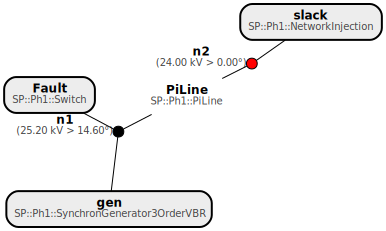

In [29]:
log_name = "SP_ReducedOrderSG_SMIB_" + "3Order"
system_sp


In [30]:


SyncGenerator = system_sp.components[0]
type(SyncGenerator)

if "SynchronGenerator" and "Order" in str(type(system_sp.components[0])):
    print("YXes")

YXes


### DPSim to CIMpy manually

In [31]:
network_sp = dict(meta_info={}, topology={})
network_sp["meta_info"]= dict(urls = {}, namespaces = {"rdf": 'http://www.w3.org/1999/02/22-rdf-syntax-ns#'})


from cimpy import utils
from cimpy.cgmes_v2_4_15 import BaseVoltage
import numpy
import cmath

B1 = BaseVoltage()

network_sp = utils.add_TopologicalNode(network_sp, "cgmes_v2_4_15", B1, 0, 0, "Node1")
network_sp = utils.add_TopologicalNode(network_sp, "cgmes_v2_4_15", B1,0 ,0, "Node2")

# PiLine Parameters, Piline -> ACLineSegment
name = system_sp.components[1].name()
r = float(str(system_sp.components[1].attr("R_series")))
x= float(str(system_sp.components[1].attr("L_series"))) * (2*numpy.pi*frequency)
bch= float(str(system_sp.components[1].attr("C_parallel"))) * (2*numpy.pi*frequency)
gch = float(str(system_pf.components[1].attr("G_parallel")))
network_sp = utils.add_ACLineSegment(network_sp, "cgmes_v2_4_15", "Node1", "Node2", r, x, bch, gch, name )

network_sp = utils.add_external_network_injection(network_sp, "cgmes_v2_4_15", "Node2", 1)

# Synchronous Machine Parameters
p = system_sp.components[0].attr("initElecPower").derive_real()
q = system_sp.components[0].attr("initElecPower").derive_imag()
ratedS = system_sp.components[0].attr("initElecPower").derive_mag()
ratedU = float(str(system_pf.components[0].attr("base_Voltage")))
targetValue = float(str(system_pf.components[0].attr("V_set")))
initialP = float(str(system_pf.components[0].attr("P_set_pu")))

Sync_generator_name = system_sp.components[0].name()
# Add Synchronous Machine to the network
network_sp = utils.add_SynchronousMachine(network_sp, "cgmes_v2_4_15", "Node1", p, q, ratedS, ratedU, targetValue, initialP, Sync_generator_name)


# Synchronous Machine TimeConstantReactance Parameters
Sync_Generator = system_sp.components[0]

inertia = Sync_Generator.attr("H")
statorResistance = 0   # because it is not modelled in DPsim
statorLeakageReactance = Sync_Generator.attr("Td0_t")
tpdo = Sync_Generator.attr("Td0_t")
tpqo = Sync_Generator.attr("Tq0_t")
tppdo = Sync_Generator.attr("Td0_s")
tppqo = Sync_Generator.attr("Tq0_s")
xDirectSubtrans = Sync_Generator.attr("Ld_s")
xDirectSync = Sync_Generator.attr("Ld")
xDirectTrans = Sync_Generator.attr("Ld_t")
xQuadSubtrans = Sync_Generator.attr("Lq_s")
xQuadSync = Sync_Generator.attr("Lq")
xQuadTrans = Sync_Generator.attr("Lq_t")
# Extend SynchronousMachine with dynamic Parameters
network_sp= utils.extend_SynchronousMachineTimeConstantReactance(network_sp, "cgmes_v2_4_15", network_sp["topology"][Sync_generator_name], 0, inertia,
            statorResistance, statorLeakageReactance, tpdo, tpqo, tppdo, tppqo, xDirectSubtrans, xDirectSync, xDirectTrans, xQuadSubtrans, xQuadSync, xQuadTrans)
network_sp

{'meta_info': {'urls': {},
  'namespaces': {'rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#'}},
 'topology': {'Node1': <cimpy.cgmes_v2_4_15.TopologicalNode.TopologicalNode at 0x7ffb92e83d30>,
  'Node1-sv': <cimpy.cgmes_v2_4_15.SvVoltage.SvVoltage at 0x7ffb92e83700>,
  'Node2': <cimpy.cgmes_v2_4_15.TopologicalNode.TopologicalNode at 0x7ffb92e83fa0>,
  'Node2-sv': <cimpy.cgmes_v2_4_15.SvVoltage.SvVoltage at 0x7ffb65003dc0>,
  'Terminal_1_ACLineSegment': <cimpy.cgmes_v2_4_15.Terminal.Terminal at 0x7ffb65003280>,
  'Terminal_2_ACLineSegment': <cimpy.cgmes_v2_4_15.Terminal.Terminal at 0x7ffb65003eb0>,
  'ACLineSegment': <cimpy.cgmes_v2_4_15.ACLineSegment.ACLineSegment at 0x7ffb65003a90>,
  'Terminal Injection 1': <cimpy.cgmes_v2_4_15.Terminal.Terminal at 0x7ffb65003520>,
  'Regulating Control 1': <cimpy.cgmes_v2_4_15.RegulatingControl.RegulatingControl at 0x7ffb65003a60>,
  'Injection 1': <cimpy.cgmes_v2_4_15.ExternalNetworkInjection.ExternalNetworkInjection at 0x7ffb650037c0>,
  'Termi

### Validation DPsim to CIMpy and back :: SP System


In [32]:
network_sp =  DPsimToCIMpy.DPsimToCIMpy(system_sp, sim_sp)
network_sp['topology']['Injection 1'].possibleProfileList


{'class': [0, 1],
 'governorSCD': [0],
 'maxP': [0],
 'maxQ': [0],
 'minP': [0],
 'minQ': [0],
 'ikSecond': [0],
 'maxInitialSymShCCurrent': [0],
 'maxR0ToX0Ratio': [0],
 'maxR1ToX1Ratio': [0],
 'maxZ0ToZ1Ratio': [0],
 'minInitialSymShCCurrent': [0],
 'minR0ToX0Ratio': [0],
 'minR1ToX1Ratio': [0],
 'minZ0ToZ1Ratio': [0],
 'voltageFactor': [0],
 'referencePriority': [1],
 'p': [1],
 'q': [1]}

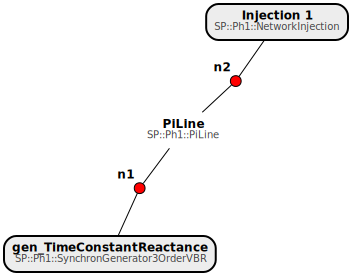

In [33]:
system_new, component=  CIMpyToDPsim.CIMpyToDPsim(network_sp, Domain.SP, "3Order")
system_new


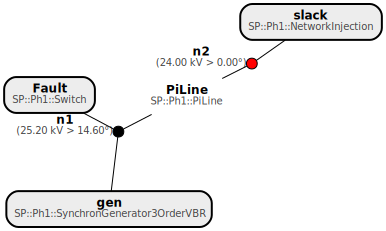

In [34]:
system_sp

In [35]:
network124 = {'meta_info': {
                'namespaces': {
                'rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#',
                'cim': 'http://iec.ch/TC57/2013/CIM-schema-cim16#',
                'md': 'http://iec.ch/TC57/61970-552/ModelDescription/1#',
                'entsoe': 'http://entsoe.eu/CIM/SchemaExtension/3/1#'},            
                'urls': {}, 
                'author': 'DPsim'},
                'topology': {}
                }
network124

{'meta_info': {'namespaces': {'rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#',
   'cim': 'http://iec.ch/TC57/2013/CIM-schema-cim16#',
   'md': 'http://iec.ch/TC57/61970-552/ModelDescription/1#',
   'entsoe': 'http://entsoe.eu/CIM/SchemaExtension/3/1#'},
  'urls': {},
  'author': 'DPsim'},
 'topology': {}}

### DPSim Object with cimexport Test


In [36]:
import cimpy
from pathlib import Path
import pytest_check as check
import pickle

activeProfileList = ['TP']              
cimpy.cim_export(network_sp, "./", 'cgmes_v2_4_15', activeProfileList )

#ref_dict_path = Path('./CIGREMV_import_reference_cgmes_v2_4_15.p')
#check_dict_pickle = pickle.load(open(ref_dict_path, 'rb'))

#for elem in import_resolved:
#    check.is_in(elem, check_dict_pickle)

File ./_Topology.xml already exists. Delete file or change file name to serialize CGMES classes.
[ERROR:] File ./_Topology.xml already exists. Delete file or change file name to serialize CGMES classes.


NameError: name 'exit' is not defined

#### Read Results DPSim

In [37]:
# read Simulink log file

file_path = os.getcwd() + "/logs/" + log_name + "/" + log_name + ".csv"
ts_dpsim_3Order = read_timeseries_dpsim(file_path)

column number: 12
results length: 20000
real column names: ['Edq0_0', 'Edq0_1', 'Idq0_0', 'Idq0_1', 'Te', 'Vdq0_0', 'Vdq0_1', 'delta', 'w_r']
complex column names: ['i_gen', 'n1.v', 'n2.v']


#### Plot and validate results

##### Electrical torque

RMSE Te  = 0.006995 (pu), which is 1.294% of the nominal value = 0.541 (pu) 


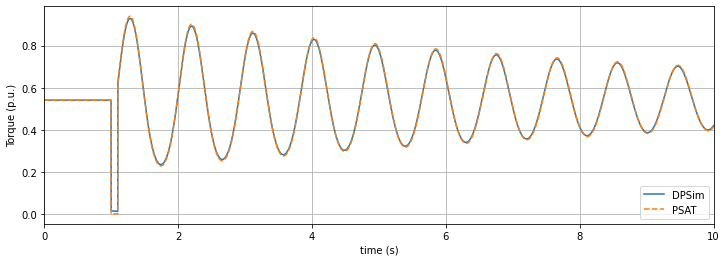

In [38]:
varname_dpsim = "Te"
varname_psat = "p"

rmse_torque = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_3Order, ts_psat_3Order, nominal_values, ylabels)

##### $E_q^{'}$

RMSE Edq0_1  = 0.000183 (pu), which is 0.019% of the nominal value = 0.945 (pu) 


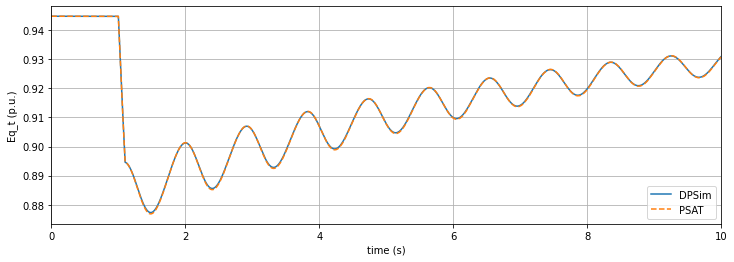

In [39]:
varname_dpsim = "Edq0_1"
varname_psat = "eq_t"

rmse_eq = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_3Order, ts_psat_3Order, nominal_values, ylabels)

##### $V_d$

RMSE Vdq0_0  = 0.006256 (pu), which is 0.979% of the nominal value = 0.639 (pu) 


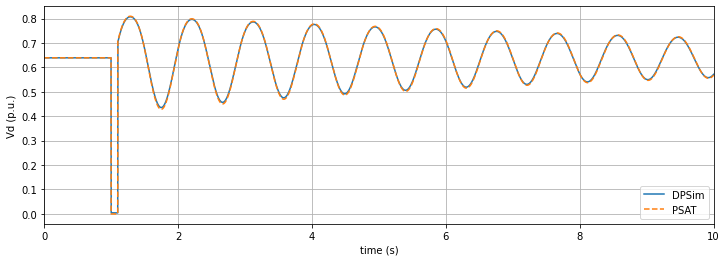

In [40]:
varname_dpsim = "Vdq0_0"
varname_psat = "vd"

rmse_vd = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_3Order, ts_psat_3Order, nominal_values, ylabels)

##### $V_q$

RMSE Vdq0_1  = 0.006747 (pu), which is 0.810% of the nominal value = 0.833 (pu) 


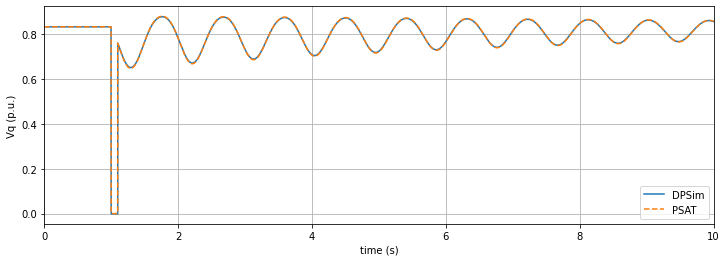

In [41]:
varname_dpsim = "Vdq0_1"
varname_psat = "vq"

rmse_vq = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_3Order, ts_psat_3Order, nominal_values, ylabels)

##### $I_d$

RMSE Idq0_0  = 0.022487 (pu), which is 6.038% of the nominal value = 0.372 (pu) 


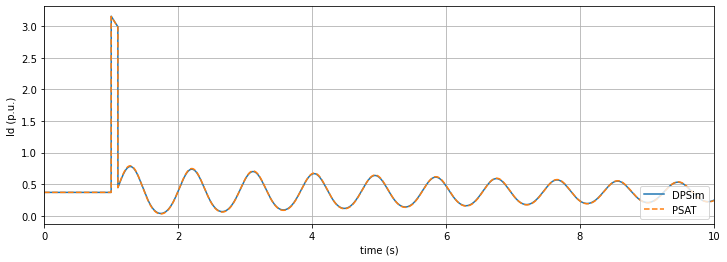

In [42]:
varname_dpsim = "Idq0_0"
varname_psat = "id"

rmse_id = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_3Order, ts_psat_3Order, nominal_values, ylabels)

##### $I_q$

RMSE Idq0_1  = 0.003555 (pu), which is 0.979% of the nominal value = 0.363 (pu) 


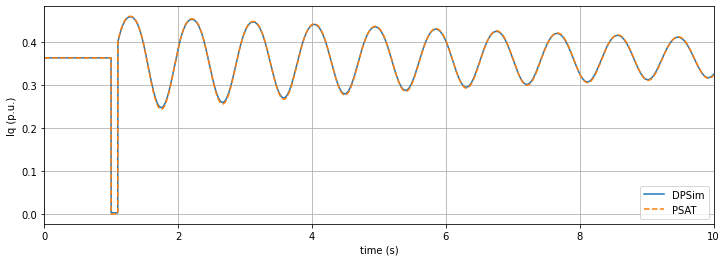

In [43]:
varname_dpsim = "Idq0_1"
varname_psat = "iq"

rmse_iq = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_3Order, ts_psat_3Order, nominal_values, ylabels)

##### Delta

RMSE delta  = 0.005919 (pu), which is 0.651% of the nominal value = 0.909 (pu) 


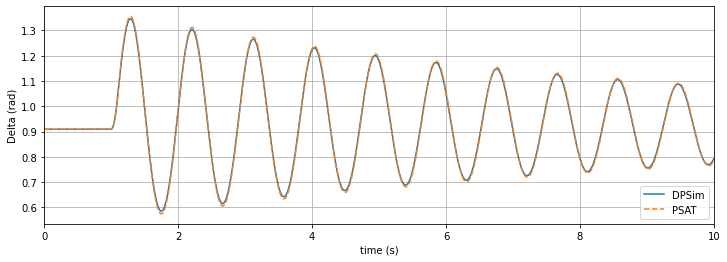

In [44]:
varname_dpsim = "delta"
varname_psat = "delta"

rmse_delta = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_3Order, ts_psat_3Order, nominal_values, ylabels)

##### Mechanical Omega

RMSE w_r  = 0.000101 (pu), which is 0.010% of the nominal value = 1.000 (pu) 


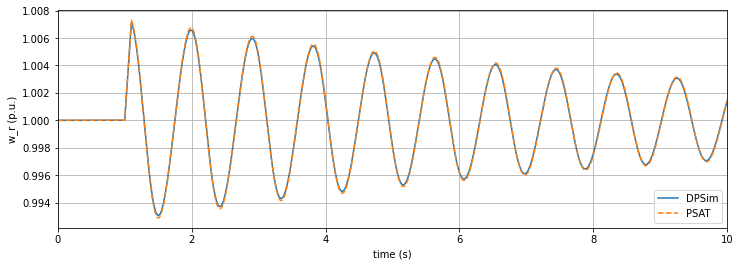

In [45]:
varname_dpsim = "w_r"
varname_psat = "omega"

rmse_omega = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_3Order, ts_psat_3Order, nominal_values, ylabels)

##### Grid voltages

RMSE n1.v  = 0.008480 (pu), which is 0.848% of the nominal value = 1.000 (pu) 


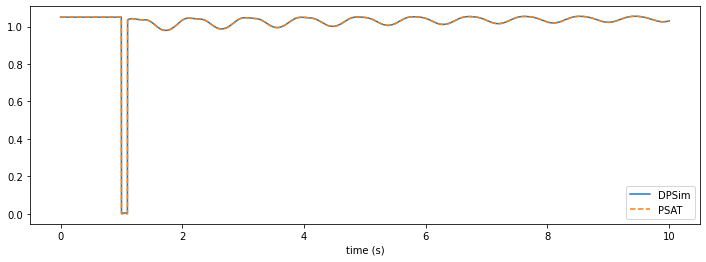

In [46]:
varname_dpsim = "n1.v"
varname_psat = "V_Bus1"

rmse_v1_abs = plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_3Order, ts_psat_3Order, nominal_grid_voltage, ylabels)

RMSE Post-Fault n1.v  = 0.154882 (deg)


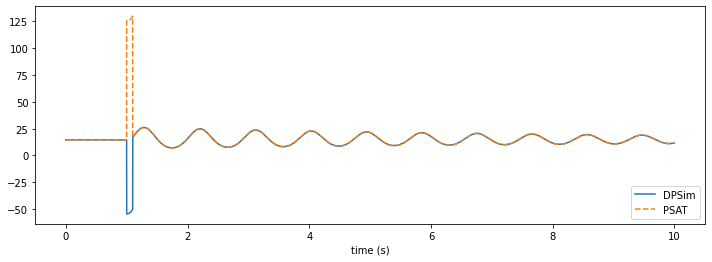

In [47]:
varname_dpsim = "n1.v"
varname_psat = "theta_bus1"

rmse_v1_angle = plot_node_volt_angle(varname_dpsim, varname_psat, ts_dpsim_3Order, ts_psat_3Order, nominal_grid_voltage, ylabels)

RMSE n2.v  = 0.000000 (pu), which is 0.000% of the nominal value = 1.000 (pu) 


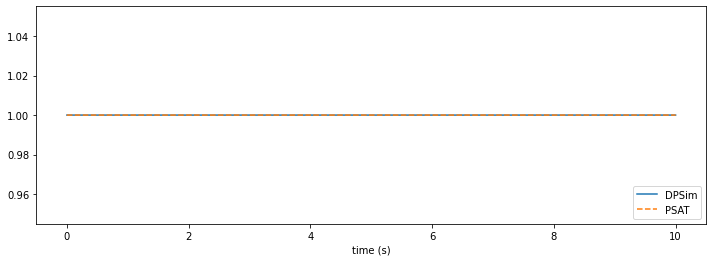

In [48]:
varname_dpsim = "n2.v"
varname_psat = "V_Bus3"

rmse_v2_abs = plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_3Order, ts_psat_3Order, nominal_grid_voltage, ylabels)

RMSE Post-Fault n2.v  = 0.000000 (deg)


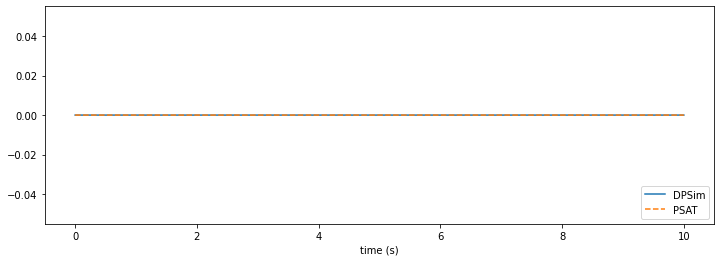

In [49]:
varname_dpsim = "n2.v"
varname_psat = "theta_bus3"

rmse_v2_angle = plot_node_volt_angle(varname_dpsim, varname_psat, ts_dpsim_3Order, ts_psat_3Order, nominal_grid_voltage, ylabels)

#### Assert

In [ ]:
tol = 1.3 # %
tol_id = 7 # %
tol_deg_v1 = 0.16 # deg
tol_deg_v2 = 1e-12 # deg

assert(rmse_torque<tol)
assert(rmse_eq<tol)
assert(rmse_vd<tol)
assert(rmse_vq<tol)
assert(rmse_id<tol_id)
assert(rmse_iq<tol)
assert(rmse_delta<tol)
assert(rmse_omega<tol)
assert(rmse_v1_abs<tol)
assert(rmse_v2_abs<tol)
assert(rmse_v1_angle<tol_deg_v1)
assert(rmse_v2_angle<tol_deg_v2)

### 4th Order Model

In [ ]:
log_name = sp_reducedOrderSG_SMIB_fault(sim_pf, gen_pf, "4Order")

1.000000e+00: Handle event time


[15:54:57.286898 PiLine warning] Zero value for Conductance, setting default value of G=1e-06 [S]
[15:54:57.288533 SP_ReducedOrderSG_SMIB_4Order info] Initialize simulation: SP_ReducedOrderSG_SMIB_4Order
[15:54:57.288680 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[15:54:57.290122 SP_ReducedOrderSG_SMIB_4Order_Solver warning] Linear solver configuration is not used!
[15:54:57.290967 SP_ReducedOrderSG_SMIB_4Order info] Scheduling tasks.
[15:54:57.291368 SP_ReducedOrderSG_SMIB_4Order info] Scheduling done.
[15:54:57.291372 SP_ReducedOrderSG_SMIB_4Order info] Opening interfaces.
[15:54:57.291373 SP_ReducedOrderSG_SMIB_4Order info] Start synchronization with remotes on interfaces
[15:54:57.291375 SP_ReducedOrderSG_SMIB_4Order info] Synchronized simulation start with remotes
[15:54:57.291377 SP_ReducedOrderSG_SMIB_4Order info] Start simulation: SP_ReducedOrderSG_SMIB_4Order
[15:54:57.291381 SP_ReducedOrderSG_SMIB_4Order info] Time step: 1.000000e-03
[15:54:57.29138

1.100000e+00: Handle event time


#### Read Results DPSim

In [ ]:
# read Simulink log file

file_path = os.getcwd() + "/logs/" + log_name + "/" + log_name + ".csv"
ts_dpsim_4Order = read_timeseries_dpsim(file_path)

TypeError: can only concatenate str (not "tuple") to str

#### Plot and validate results

##### Electrical torque

In [ ]:
varname_dpsim = "Te"
varname_psat = "p"

rmse_torque = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

##### $E_d^{'}$

In [ ]:
varname_dpsim = "Edq0_0"
varname_psat = "ed_t"

rmse_ed = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

##### $E_q^{'}$

In [ ]:
varname_dpsim = "Edq0_1"
varname_psat = "eq_t"

rmse_eq = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

##### $V_d$

In [ ]:
varname_dpsim = "Vdq0_0"
varname_psat = "vd"

rmse_vd = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

##### $V_q$

In [ ]:
varname_dpsim = "Vdq0_1"
varname_psat = "vq"

rmse_vq = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

##### $I_d$

In [ ]:
varname_dpsim = "Idq0_0"
varname_psat = "id"

rmse_id = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

##### $I_q$

In [ ]:
varname_dpsim = "Idq0_1"
varname_psat = "iq"

rmse_iq = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

##### Delta

In [ ]:
varname_dpsim = "delta"
varname_psat = "delta"

rmse_delta = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

##### Mechanical Omega

In [ ]:
varname_dpsim = "w_r"
varname_psat = "omega"

rmse_omega = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_values, ylabels)

##### Grid voltages

In [ ]:
varname_dpsim = "n1.v"
varname_psat = "V_Bus1"

rmse_v1_abs = plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_grid_voltage, ylabels)

In [ ]:
varname_dpsim = "n1.v"
varname_psat = "theta_bus1"

rmse_v1_angle = plot_node_volt_angle(varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_grid_voltage, ylabels)

In [ ]:
varname_dpsim = "n2.v"
varname_psat = "V_Bus3"

rmse_v2_abs = plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_grid_voltage, ylabels)

In [ ]:
varname_dpsim = "n2.v"
varname_psat = "theta_bus3"

rmse_v2_angle = plot_node_volt_angle(varname_dpsim, varname_psat, ts_dpsim_4Order, ts_psat_4Order, nominal_grid_voltage, ylabels)

#### Assert

In [ ]:
tol = 1 # %
tol_id = 6 # %
tol_iq = 2.3 # %
tol_deg_v1 = 0.2 # deg
tol_deg_v2 = 1e-12 # deg

assert(rmse_torque<tol)
assert(rmse_ed<tol)
assert(rmse_eq<tol)
assert(rmse_vd<tol)
assert(rmse_vq<tol)
assert(rmse_id<tol_id)
assert(rmse_iq<tol_iq)
assert(rmse_delta<tol)
assert(rmse_omega<tol)
assert(rmse_v1_abs<tol)
assert(rmse_v2_abs<tol)
assert(rmse_v1_angle<tol_deg_v1)
assert(rmse_v2_angle<tol_deg_v2)

### 6th Order Model (Marconato's model)

In [ ]:
log_name = sp_reducedOrderSG_SMIB_fault(sim_pf, gen_pf, "6aOrder")

#### Read DPSim results

In [ ]:
# read Simulink log file

file_path = os.getcwd() + "/logs/" + log_name + "/" + log_name + ".csv"
ts_dpsim_6aOrder = read_timeseries_dpsim(file_path)

#### Plot and validate results

##### Electrical Torque

In [ ]:
varname_dpsim = "Te"
varname_psat = "p"

rmse_torque = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_6aOrder, ts_psat_6Order, nominal_values, ylabels)

##### $E_d^{'}$

In [ ]:
varname_dpsim = "Edq0_t_0"
varname_psat = "ed_t"

rmse_ed = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_6aOrder, ts_psat_6Order, nominal_values, ylabels)

##### $E_q^{'}$

In [ ]:
varname_dpsim = "Edq0_t_1"
varname_psat = "eq_t"

rmse_eq = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_6aOrder, ts_psat_6Order, nominal_values, ylabels)

##### $E_d^{''}$

In [ ]:
varname_dpsim = "Edq0_s_0"
varname_psat = "ed_s"

rmse_ed_s = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_6aOrder, ts_psat_6Order, nominal_values, ylabels)

##### $E_q^{''}$

In [ ]:
varname_dpsim = "Edq0_s_1"
varname_psat = "eq_s"

rmse_eq_s = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_6aOrder, ts_psat_6Order, nominal_values, ylabels)

##### $V_d$

In [ ]:
varname_dpsim = "Vdq0_0"
varname_psat = "vd"

rmse_vd = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_6aOrder, ts_psat_6Order, nominal_values, ylabels)

##### $V_q$

In [ ]:
varname_dpsim = "Vdq0_1"
varname_psat = "vq"

rmse_vq = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_6aOrder, ts_psat_6Order, nominal_values, ylabels)

##### $I_d$

In [ ]:
varname_dpsim = "Idq0_0"
varname_psat = "id"

rmse_id = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_6aOrder, ts_psat_6Order, nominal_values, ylabels)

##### $I_q$

In [ ]:
varname_dpsim = "Idq0_1"
varname_psat = "iq"

rmse_iq = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_6aOrder, ts_psat_6Order, nominal_values, ylabels)

##### Delta

In [ ]:
varname_dpsim = "delta"
varname_psat = "delta"

rmse_delta = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_6aOrder, ts_psat_6Order, nominal_values, ylabels)

##### Mechanical omega

In [ ]:
varname_dpsim = "w_r"
varname_psat = "omega"

rmse_omega = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_6aOrder, ts_psat_6Order, nominal_values, ylabels)

##### Grid voltages

In [ ]:
varname_dpsim = "n1.v"
varname_psat = "V_Bus1"

rmse_v1_abs = plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_6aOrder, ts_psat_6Order, nominal_grid_voltage, ylabels)

In [ ]:
varname_dpsim = "n1.v"
varname_psat = "theta_bus1"

rmse_v1_angle = plot_node_volt_angle(varname_dpsim, varname_psat, ts_dpsim_6aOrder, ts_psat_6Order, nominal_grid_voltage, ylabels)

In [ ]:
varname_dpsim = "n2.v"
varname_psat = "V_Bus3"

rmse_v2_abs = plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_6aOrder, ts_psat_6Order, nominal_grid_voltage, ylabels)

In [ ]:
varname_dpsim = "n2.v"
varname_psat = "theta_bus3"

rmse_v2_angle = plot_node_volt_angle(varname_dpsim, varname_psat, ts_dpsim_6aOrder, ts_psat_6Order, nominal_grid_voltage, ylabels)

### Assert

In [ ]:
tol = 1.3 #%
tol_id = 7.3
tol_iq = 4.8
tol_deg_v1 = 0.13 # deg
tol_deg_v2 = 1e-12 # deg

assert(rmse_torque<tol)
assert(rmse_ed<tol)
assert(rmse_eq<tol)
assert(rmse_ed_s<tol)
assert(rmse_eq_s<tol)
assert(rmse_vd<tol)
assert(rmse_vq<tol)
assert(rmse_id<tol_id)
assert(rmse_iq<tol_iq)
assert(rmse_delta<tol)
assert(rmse_omega<tol)
assert(rmse_v1_abs<tol)
assert(rmse_v2_abs<tol)
assert(rmse_v1_angle<tol_deg_v1)
assert(rmse_v2_angle<tol_deg_v2)

### Validation 6th Order Model (Anderson-Fouad's model)

In [ ]:
log_name = sp_reducedOrderSG_SMIB_fault(sim_pf, gen_pf, "6bOrder")

#### Read DPSim Results

In [ ]:
# read Simulink log file

file_path = os.getcwd() + "/logs/" + log_name + "/" + log_name + ".csv"
ts_dpsim_6bOrder = read_timeseries_dpsim(file_path)

#### Plot and validate results

##### Electrical Torque

In [ ]:
varname_dpsim = "Te"
varname_psat = "p"

rmse_torque = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_6bOrder, ts_psat_6Order, nominal_values, ylabels)

##### $V_d$

In [ ]:
varname_dpsim = "Vdq0_0"
varname_psat = "vd"

rmse_vd = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_6bOrder, ts_psat_6Order, nominal_values, ylabels)

##### $V_q$

In [ ]:
varname_dpsim = "Vdq0_1"
varname_psat = "vq"

rmse_vq = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_6bOrder, ts_psat_6Order, nominal_values, ylabels)

##### $I_d$

In [ ]:
varname_dpsim = "Idq0_0"
varname_psat = "id"

rmse_id = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_6bOrder, ts_psat_6Order, nominal_values, ylabels)

##### $I_q$

In [ ]:
varname_dpsim = "Idq0_1"
varname_psat = "iq"

rmse_iq = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_6bOrder, ts_psat_6Order, nominal_values, ylabels)

##### Delta

In [ ]:
varname_dpsim = "delta"
varname_psat = "delta"

rmse_delta = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_6bOrder, ts_psat_6Order, nominal_values, ylabels)

##### Mechanical omega

In [ ]:
varname_dpsim = "w_r"
varname_psat = "omega"

rmse_omega = plot_variable(titles, varname_dpsim, varname_psat, ts_dpsim_6bOrder, ts_psat_6Order, nominal_values, ylabels)

##### Grid voltages

In [ ]:
varname_dpsim = "n1.v"
varname_psat = "V_Bus1"

rmse_v1_abs = plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_6bOrder, ts_psat_6Order, nominal_grid_voltage, ylabels)

In [ ]:
varname_dpsim = "n1.v"
varname_psat = "theta_bus1"

rmse_v1_angle = plot_node_volt_angle(varname_dpsim, varname_psat, ts_dpsim_6bOrder, ts_psat_6Order, nominal_grid_voltage, ylabels)

In [ ]:
varname_dpsim = "n2.v"
varname_psat = "V_Bus3"

rmse_v2_abs = plot_node_volt_abs(varname_dpsim, varname_psat, ts_dpsim_6bOrder, ts_psat_6Order, nominal_grid_voltage, ylabels)

In [ ]:
varname_dpsim = "n2.v"
varname_psat = "theta_bus3"

rmse_v2_angle = plot_node_volt_angle(varname_dpsim, varname_psat, ts_dpsim_6bOrder, ts_psat_6Order, nominal_grid_voltage, ylabels)

##### Assert

In [ ]:
tol = 1 #%
tol_id = 7.6 #%
tol_iq = 5.2 #%
tol_torque = 1.8
tol_deg_v1 = 0.25 # deg
tol_deg_v2 = 1e-12 # deg

assert(rmse_torque<tol_torque)
assert(rmse_vd<tol)
assert(rmse_vq<tol)
assert(rmse_id<tol_id)
assert(rmse_iq<tol_iq)
assert(rmse_delta<tol)
assert(rmse_omega<tol)
assert(rmse_v1_abs<tol)
assert(rmse_v2_abs<tol)
assert(rmse_v1_angle<tol_deg_v1)
assert(rmse_v2_angle<tol_deg_v2)